# Collecting final annotations  
**In this Notebook**: Annotations from a1 and a2 are collected and processed to constitute an annotated corpus of claims. Also: some exploratory analyses in terms of sequence patterns and linguistic characteristics of claim categories.

In [1]:
import numpy as np
import sys
sys.path.insert(0, "../") 
from utils.ClaimDB import ClaimDB
from utils.Paper import Paper
import pickle
import json
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

## Load annotations from doccano files

### Annotations by Clémentine

In [30]:
data_dir = "final-anno-results/final-anno-clementine/"

# load annotations made in the admin interface
admin = pd.read_csv(f"{data_dir}admin.csv")
# load annotations made in the anno2 interface
anno2 = pd.read_csv(f"{data_dir}anno2.csv")

# join these annotations, while removing eventual duplicates and empty articles
anno_admin = admin[~admin["label"].isna()]
admin_paper_list = list(anno_admin["paper_title"].unique())
admin_paper_list.remove("Word-to-Word Models of Translational Equivalence")
admin = admin[admin["paper_title"].isin(admin_paper_list)]
anno2 = anno2[~anno2["paper_title"].isin(admin_paper_list)]

for title in anno2["paper_title"].unique():
    # check if some papers are not annotated at all
    if anno2[(anno2["paper_title"] == title) & (~anno2["label"].isna())].shape[0] == 0:
        print(title)
        # remove the paper from the list
        anno2 = anno2[anno2["paper_title"] != title]
print()

anno_clem = pd.concat([anno_admin, anno2])
anno_clem["annotator"] = ["clementine"] * anno_clem.shape[0]

print("Annotations dataset dimensions:", anno_clem.shape)
print("Number of annotated papers:", anno_clem["paper_title"].unique().shape[0])

Re-evaluating Automatic Summarization with {BLEU} and 192 Shades of {ROUGE}
Template-Based Question Generation from Retrieved Sentences for Improved Unsupervised Question Answering

Annotations dataset dimensions: (11614, 13)
Number of annotated papers: 116


### Annotations by Fanny

In [31]:
data_dir = "final-anno-results/final-anno-fanny/"

# load annotations made in the admin interface
admin = pd.read_csv(f"{data_dir}admin.csv")
# load annotations made in the anno1 interface
anno1 = pd.read_csv(f"{data_dir}anno1.csv")

annotated_titles_admin = admin[~admin["label"].isna()]["paper_title"].unique().tolist()
print("Number of annotated papers in admin:", len(annotated_titles_admin))
annotated_titles_anno1 = anno1[~anno1["label"].isna()]["paper_title"].unique().tolist()
print("Number of annotated papers in anno1:", len(annotated_titles_anno1))

# are there some common papers between the two datasets?
common_papers = set(annotated_titles_admin).intersection(set(annotated_titles_anno1))
print("Number of common papers:", len(common_papers))
for cp in common_papers:
    print(cp)

# it seems like this article was found twice in the dataset, we'll remove it
annotated_titles_admin.remove(list(common_papers)[0])
annotated_titles_anno1.remove(list(common_papers)[0])

Number of annotated papers in admin: 12
Number of annotated papers in anno1: 32
Number of common papers: 1
A Corpus-based Evaluation of Lexical Components of a Domainspecific Text
  to Knowledge Mapping Prototype


In [33]:
admin = admin[admin["paper_title"].isin(annotated_titles_admin)]
admin["annotator"] = ["clementine"] * admin.shape[0]

anno1 = anno1[anno1["paper_title"].isin(annotated_titles_anno1)]
anno1["annotator"] = ["fanny"] * anno1.shape[0]

print(admin.shape)
print(anno1.shape)

(1061, 13)
(3170, 13)


In [34]:
anno_fanny = pd.concat([admin, anno1])
print("Annotations dataset dimensions:", anno_fanny.shape)
print("Number of annotated papers:", anno_fanny["paper_title"].unique().shape[0])

Annotations dataset dimensions: (4231, 13)
Number of annotated papers: 42


In [36]:
# Finally, group all the annotations
all_anno = pd.concat([anno_clem, anno_fanny])
print("Annotations dataset dimensions:", all_anno.shape)
print("Number of annotated papers:", all_anno["paper_title"].unique().shape[0])

Annotations dataset dimensions: (15845, 13)
Number of annotated papers: 156


## Post-processing

In [37]:
# replace na with empty strings
all_anno.fillna("", inplace=True)

# consider labels "rw" and "error" as separate column tags
all_anno["rw"] = all_anno["label"].apply(lambda x: True if "rw" in x else False)
all_anno["error"] = all_anno["label"].apply(lambda x: True if "error" in x else False)

# remove "rw" and "error" from the label
LABELS = ["context-AIC", "outline-AIC", "contribution-AIC", "result", "limitation", "impact", "directions"]
all_anno["label"] = all_anno["label"].apply(lambda x: "#".join([l for l in LABELS if l in x]))

# use the "nc" labels for empty all_annotations
all_anno["label"] = all_anno["label"].apply(lambda x: "nc" if x == "" else x)

In [38]:
# collect all_annotator feedback
small_sep_s = "------------------------------------------------------------------------------------------\n"
big_sep_s = "==========================================================================================\n"

all_anno_feedback = all_anno[all_anno["text"].str.contains(f"{big_sep_s}Annotator feedback")]
print(all_anno_feedback.shape)

all_anno_fb_1 = all_anno_feedback[(all_anno_feedback["text"].str.contains("1.")) & (all_anno_feedback["label"] == "outline-AIC")]
all_anno_fb_2 = all_anno_feedback[(all_anno_feedback["text"].str.contains("2.")) & (all_anno_feedback["label"] == "outline-AIC")]
all_anno_fb_3 = all_anno_feedback[(all_anno_feedback["text"].str.contains("3.")) & (all_anno_feedback["label"] == "outline-AIC")]

papers_with_issue_1 = all_anno_fb_1["paper_title"].unique()
papers_with_issue_2 = all_anno_fb_2["paper_title"].unique()
papers_with_issue_3 = all_anno_fb_3["paper_title"].unique()

print("Papers with issue 1:", len(papers_with_issue_1))
print("Papers with issue 2:", len(papers_with_issue_2))
print("Papers with issue 3:", len(papers_with_issue_3))

(472, 15)
Papers with issue 1: 20
Papers with issue 2: 35
Papers with issue 3: 0


In [39]:
all_papers_with_issues = set(papers_with_issue_1).union(set(papers_with_issue_2)).union(set(papers_with_issue_3))

issues = []
for p in all_papers_with_issues:
    issues.append({
        "paper_title": p,
        "issue_1": p in papers_with_issue_1,
        "issue_2": p in papers_with_issue_2,
        "issue_3": p in papers_with_issue_3
    })

issues = pd.DataFrame(issues)
issues

,paper_title,issue_1,issue_2,issue_3
0,Lattice-based Improvements for Voice Triggerin...,True,False,False
1,Using Supervised Bigram-based {ILP} for Extrac...,False,True,False
2,Two Languages Are More Informative Than One,False,True,False
3,Development and Evaluation of a Broad-Coverage...,False,True,False
4,Factual or Satisfactory: What Search Results A...,False,True,False
5,Text Understanding With Multiple Knowledge Sou...,True,False,False
6,Machine Learning of User Profiles: Representat...,False,True,False
7,A Data-Oriented Approach to Semantic Interpret...,False,True,False
8,Word-Sense Distinguishability and Inter-Coder ...,False,True,False
9,Tied Mixtures in the {L}incoln Robust {CSR},True,False,False


In [40]:
# remove feedback from the all_annotations
all_anno = all_anno[~all_anno["text"].str.contains(f"{big_sep_s}Annotator feedback")]
print(all_anno.shape)

(15373, 15)


In [41]:
# remove surrounding text (paper title, section)
import re
sections = []
texts = []

for i, row in all_anno.iterrows():

    if small_sep_s in row["text"]:
        split_ = row["text"].split(small_sep_s)
        text = split_[-1]
        section = split_[0].split(big_sep_s)[-1]
        section = re.search(r"\d+.(.*) --", section).group(1).strip()

    else:
        split_ = row["text"].split(big_sep_s)
        text = split_[-1]
        section = split_[1]
        section = re.search(r"\d+.(.*) --", section).group(1).strip()

    texts.append(text)
    sections.append(section)


all_anno["text"] = texts
all_anno["section"] = sections

In [42]:
print(all_anno.shape)
# remove duplicate all_annotations (found for one article)
all_anno.drop_duplicates(subset = ["text"], keep = "first", inplace = True)
print(all_anno.shape)
# ensure that we kept the version with all_annotations
all_anno[all_anno["paper_title"].str.startswith("Evaluation of the NLP Components of the OVIS2")].head()

(15373, 16)
(14792, 16)


,id,text,doc_id,paper_title,paper_structure,year,prev_text,prev_section,next_text,next_section,label,Comments,annotator,rw,error,section
11236,71088,The NWO Priority Programme Language and Spee...,6497705,Evaluation of the NLP Components of the OVIS2 ...,0. abstract\n1. Introduction\n2. Two NLP Compo...,1999,,,"In the Programme, two alternative natural lang...",abstract,context-AIC,,clementine,False,False,abstract
11237,71089,"In the Programme, two alternative natural lang...",6497706,Evaluation of the NLP Components of the OVIS2 ...,0. abstract\n1. Introduction\n2. Two NLP Compo...,1999,The NWO Priority Programme Language and Spee...,abstract,"In order to compare the NLP modules, a formal ...",abstract,context-AIC,,clementine,False,False,abstract
11238,71090,"In order to compare the NLP modules, a formal ...",6497707,Evaluation of the NLP Components of the OVIS2 ...,0. abstract\n1. Introduction\n2. Two NLP Compo...,1999,"In the Programme, two alternative natural lang...",abstract,This paper describes the evaluation procedure ...,abstract,context-AIC,,clementine,False,False,abstract
11239,71091,This paper describes the evaluation procedure ...,6497708,Evaluation of the NLP Components of the OVIS2 ...,0. abstract\n1. Introduction\n2. Two NLP Compo...,1999,"In order to compare the NLP modules, a formal ...",abstract,The grammar-based component performs much bett...,abstract,contribution-AIC,,clementine,False,False,abstract
11240,71092,The grammar-based component performs much bett...,6497709,Evaluation of the NLP Components of the OVIS2 ...,0. abstract\n1. Introduction\n2. Two NLP Compo...,1999,This paper describes the evaluation procedure ...,abstract,The NWO Priority Programme Language and Speech...,Introduction,result,,clementine,False,False,abstract


In [102]:
# drop useless columns
all_anno.drop(columns = ["prev_section", "prev_text", "next_section", "next_text"], inplace = True)
all_anno = all_anno[["id", "doc_id", "paper_title", "paper_structure", "year", "text", "section", "label", "rw", "error", "Comments"]]

In [43]:
anno = all_anno
anno.head()

,id,text,doc_id,paper_title,paper_structure,year,prev_text,prev_section,next_text,next_section,label,Comments,annotator,rw,error,section
0,59852,Most Semantic Role Labeling (SRL) approaches a...,3435904,Multi-Task Active Learning for Neural Semantic...,0. abstract\n1. Introduction\n2. Related Work\...,2018,,,"In this paper, we propose a Multi-Task Active ...",abstract,context-AIC,,clementine,False,False,abstract
1,59853,"In this paper, we propose a Multi-Task Active ...",3435905,Multi-Task Active Learning for Neural Semantic...,0. abstract\n1. Introduction\n2. Related Work\...,2018,Most Semantic Role Labeling (SRL) approaches a...,abstract,We evaluate our approach on Indonesian convers...,abstract,contribution-AIC,,clementine,False,False,abstract
2,59854,We evaluate our approach on Indonesian convers...,3435906,Multi-Task Active Learning for Neural Semantic...,0. abstract\n1. Introduction\n2. Related Work\...,2018,"In this paper, we propose a Multi-Task Active ...",abstract,Our experiments show that multi-task active le...,abstract,contribution-AIC,,clementine,False,False,abstract
3,59855,Our experiments show that multi-task active le...,3435907,Multi-Task Active Learning for Neural Semantic...,0. abstract\n1. Introduction\n2. Related Work\...,2018,We evaluate our approach on Indonesian convers...,abstract,"According to our results, active learning is m...",abstract,result,,clementine,False,False,abstract
4,59856,"According to our results, active learning is m...",3435908,Multi-Task Active Learning for Neural Semantic...,0. abstract\n1. Introduction\n2. Related Work\...,2018,Our experiments show that multi-task active le...,abstract,We also introduce a new dataset for SRL in Ind...,abstract,result,,clementine,False,False,abstract


## Inspect labels distribution

In [44]:
n = len(anno["paper_title"].unique())
anno["label"].value_counts().head(n)

label
nc                                     6378
result                                 3042
context-AIC                            2131
contribution-AIC                       1679
directions                              365
limitation                              273
outline-AIC                             263
result#limitation                       214
contribution-AIC#result                 128
impact                                   66
outline-AIC#contribution-AIC             66
limitation#directions                    28
contribution-AIC#impact                  25
result#impact                            24
result#directions                        20
context-AIC#impact                       16
contribution-AIC#limitation              12
impact#directions                        10
context-AIC#result                        7
context-AIC#directions                    7
outline-AIC#result                        7
context-AIC#contribution-AIC              6
context-AIC#limitation    

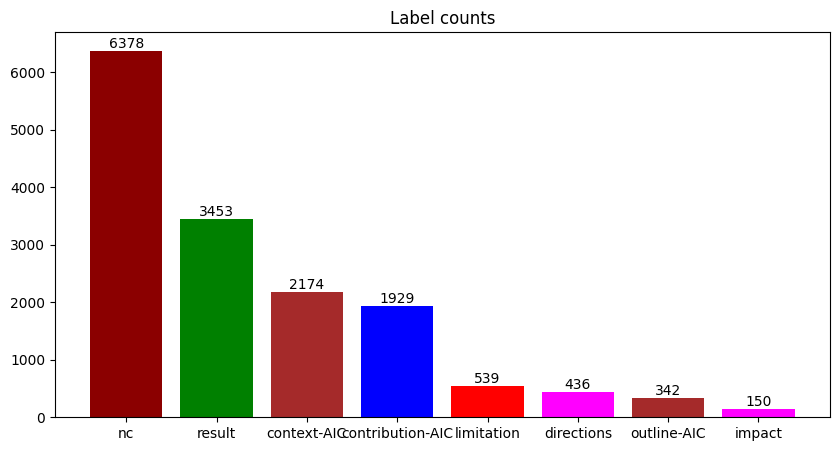

In [45]:
label_counts = {}

LABELS = ["context-AIC", "outline-AIC", "contribution-AIC", "result", "limitation", "impact", "directions"]
LABELS.append("nc")

for label in LABELS:
    label_counts[label] = anno[anno["label"].str.contains(label)].shape[0]

# sort the labels by frequency
label_counts = dict(sorted(label_counts.items(), key=lambda item: item[1], reverse=True))

# plot the label counts
palette_dict = {"nc": "darkred",
                "result":"green",
                "context-AIC":"brown",
                "outline-AIC":"brown",
                "contribution-AIC":"blue",
                "limitation":"red",
                "impact": "magenta",
                "directions": "magenta"}

plt.figure(figsize=(10, 5))
plt.bar(label_counts.keys(), label_counts.values(), color=[palette_dict[label] for label in label_counts.keys()])
plt.title("Label counts")

# Add values on top of the bars
for label, count in label_counts.items():
    plt.text(label, count, str(count), ha='center', va='bottom')

plt.show()

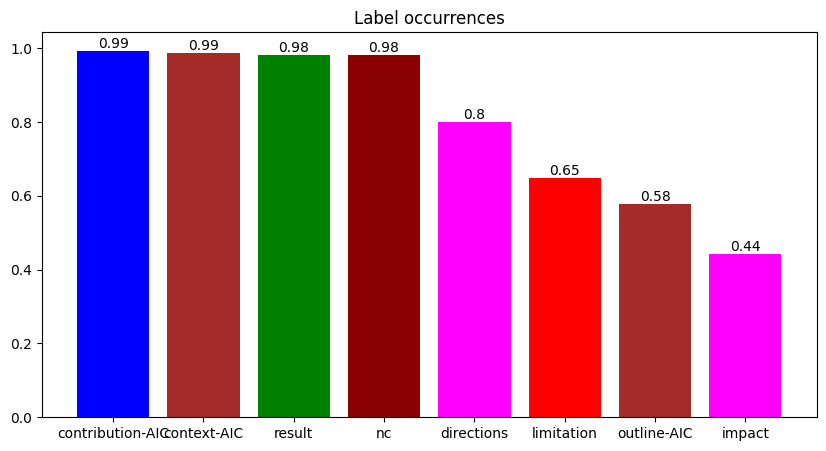

In [46]:
label_occurrences = {}
N = len(anno["paper_title"].unique())

for label in LABELS:
    occ = anno[anno["label"].str.contains(label)]
    label_occurrences[label] = len(occ["paper_title"].unique()) / N

# sort the labels by frequency
label_occurrences = dict(sorted(label_occurrences.items(), key=lambda item: item[1], reverse=True))

# plot the label counts
plt.figure(figsize=(10, 5))
plt.bar(label_occurrences.keys(), label_occurrences.values(), color=[palette_dict[label] for label in label_occurrences.keys()])
plt.title("Label occurrences")

# Add values on top of the bars
for label, count in label_occurrences.items():
    plt.text(label, count, str(round(count, 2)), ha='center', va='bottom')

plt.show()


In [47]:
len(anno[anno["label"].str.contains("limitation")].paper_title.unique())

101

In [48]:
for lim in anno[anno["label"].str.contains("limitation")].text.values:
    print(lim)
    print()

Our error analysis reveals some different obstacles from English SRL to work on in the future. 

There are several promising avenues for extending this work to Portuguese (and other languages), but the datasets currently available in Portuguese are not as extensive as Google News or as well tested; so, in this paper the plug-in is used to identify the similarity between an input article in English and pre-classified articles in English. 

Second, the notion of similar is too broad.

Texts can be similar but completely contradictory.

The errors described in this section are in addition to the errors due to misspellings and informal language.

These erroneous results have been obtained from both version 1 and 2.

The positive word leads to the prediction by C-Feel-It where in fact, it is a negative tweet for the human annotator.

The words 'pain', 'killers', etc. in the tweet give an indication to C-Feel-It that the tweet is negative.

This misguided implication is because of multiple s

In [49]:
anno.head()

,id,text,doc_id,paper_title,paper_structure,year,prev_text,prev_section,next_text,next_section,label,Comments,annotator,rw,error,section
0,59852,Most Semantic Role Labeling (SRL) approaches a...,3435904,Multi-Task Active Learning for Neural Semantic...,0. abstract\n1. Introduction\n2. Related Work\...,2018,,,"In this paper, we propose a Multi-Task Active ...",abstract,context-AIC,,clementine,False,False,abstract
1,59853,"In this paper, we propose a Multi-Task Active ...",3435905,Multi-Task Active Learning for Neural Semantic...,0. abstract\n1. Introduction\n2. Related Work\...,2018,Most Semantic Role Labeling (SRL) approaches a...,abstract,We evaluate our approach on Indonesian convers...,abstract,contribution-AIC,,clementine,False,False,abstract
2,59854,We evaluate our approach on Indonesian convers...,3435906,Multi-Task Active Learning for Neural Semantic...,0. abstract\n1. Introduction\n2. Related Work\...,2018,"In this paper, we propose a Multi-Task Active ...",abstract,Our experiments show that multi-task active le...,abstract,contribution-AIC,,clementine,False,False,abstract
3,59855,Our experiments show that multi-task active le...,3435907,Multi-Task Active Learning for Neural Semantic...,0. abstract\n1. Introduction\n2. Related Work\...,2018,We evaluate our approach on Indonesian convers...,abstract,"According to our results, active learning is m...",abstract,result,,clementine,False,False,abstract
4,59856,"According to our results, active learning is m...",3435908,Multi-Task Active Learning for Neural Semantic...,0. abstract\n1. Introduction\n2. Related Work\...,2018,Our experiments show that multi-task active le...,abstract,We also introduce a new dataset for SRL in Ind...,abstract,result,,clementine,False,False,abstract


In [50]:
anno[anno["paper_title"].str.startswith("Discourse Planning as an Optimi")].head()

,id,text,doc_id,paper_title,paper_structure,year,prev_text,prev_section,next_text,next_section,label,Comments,annotator,rw,error,section
1817,61669,Discourse planning systems developed to date a...,515517,Discourse Planning as an Optimization Process,0. abstract\n1. Introduction\n2. Generating th...,1994,,,"However, they lack a global criterion for sele...",abstract,context-AIC,,clementine,False,False,abstract
1818,61670,"However, they lack a global criterion for sele...",515518,Discourse Planning as an Optimization Process,0. abstract\n1. Introduction\n2. Generating th...,1994,Discourse planning systems developed to date a...,abstract,"In this paper, we cast the problem of planning...",abstract,context-AIC,,clementine,False,False,abstract
1819,61671,"In this paper, we cast the problem of planning...",515519,Discourse Planning as an Optimization Process,0. abstract\n1. Introduction\n2. Generating th...,1994,"However, they lack a global criterion for sele...",abstract,"In particular, we consider two such criteria: ...",abstract,contribution-AIC,,clementine,False,False,abstract
1820,61672,"In particular, we consider two such criteria: ...",515520,Discourse Planning as an Optimization Process,0. abstract\n1. Introduction\n2. Generating th...,1994,"In this paper, we cast the problem of planning...",abstract,These criteria are embodied in a discourse pla...,abstract,contribution-AIC,,clementine,False,False,abstract
1821,61673,These criteria are embodied in a discourse pla...,515521,Discourse Planning as an Optimization Process,0. abstract\n1. Introduction\n2. Generating th...,1994,"In particular, we consider two such criteria: ...",abstract,This mechanism is part of a discourse planning...,abstract,contribution-AIC,,clementine,False,False,abstract


### Labels vs. multi-labels

In [51]:
print("Single label:", anno[~anno["label"].str.contains("#")].shape[0])
print(">1 label:", anno[anno["label"].str.contains("#")].shape[0])
print("Total:", anno.shape[0])

Single label: 14197
>1 label: 595
Total: 14792


### Store annotations

In [112]:
anno.to_csv("processed-annotations-11-06.csv", index = False)

## Sequences

In [52]:
# consecutive claims in the same paper, in the same section, and sharing the same label will be considered as a sequence.
sequences = []

last_pt = ""
last_sec = ""
last_labels = []
last_seq = {}

for i, row in anno.iterrows():
    current_pt = row["paper_title"]
    current_sec = row["section"]
    current_labels = row["label"]

    if current_pt != last_pt or current_sec != last_sec or current_labels != last_labels:
        # store the last sequence (if not empty)
        if last_seq != {}:
            sequences.append(last_seq)
        
        # start a new sequence
        seq = {"ids": [row["id"]], "doc_ids": [row["doc_id"]],
               "paper_title": current_pt, "text": row["text"], "section": current_sec, "label": current_labels,
               "rw": row["rw"], "error": row["error"], "Comments": row["Comments"]}
        
    else:
        # update the current sequence
        seq["ids"].append(row["id"])
        seq["doc_ids"].append(row["doc_id"])
        seq["text"] += " " + row["text"]
        seq["rw"] = seq["rw"] or row["rw"]
        seq["error"] = seq["error"] or row["error"]
        seq["Comments"] += " " + row["Comments"]

    last_pt = current_pt
    last_sec = current_sec
    last_labels = current_labels
    last_seq = seq

# store the last sequence (if not empty)
if seq != {}:
    sequences.append(last_seq)

# create a dataframe from the sequences
seq_df = pd.DataFrame(sequences)
print(seq_df.shape)    

(4272, 9)


In [53]:
seq_df.head()

,ids,doc_ids,paper_title,text,section,label,rw,error,Comments
0,[59852],[3435904],Multi-Task Active Learning for Neural Semantic...,Most Semantic Role Labeling (SRL) approaches a...,abstract,context-AIC,False,False,
1,"[59853, 59854]","[3435905, 3435906]",Multi-Task Active Learning for Neural Semantic...,"In this paper, we propose a Multi-Task Active ...",abstract,contribution-AIC,False,False,
2,"[59855, 59856]","[3435907, 3435908]",Multi-Task Active Learning for Neural Semantic...,Our experiments show that multi-task active le...,abstract,result,False,False,
3,[59857],[3435909],Multi-Task Active Learning for Neural Semantic...,We also introduce a new dataset for SRL in Ind...,abstract,contribution-AIC#impact,False,False,
4,"[59858, 59859, 59860, 59861, 59862, 59863, 598...","[3435910, 3435911, 3435912, 3435913, 3435914, ...",Multi-Task Active Learning for Neural Semantic...,Semantic Role Labeling (SRL) extracts predicat...,Introduction,context-AIC,True,False,


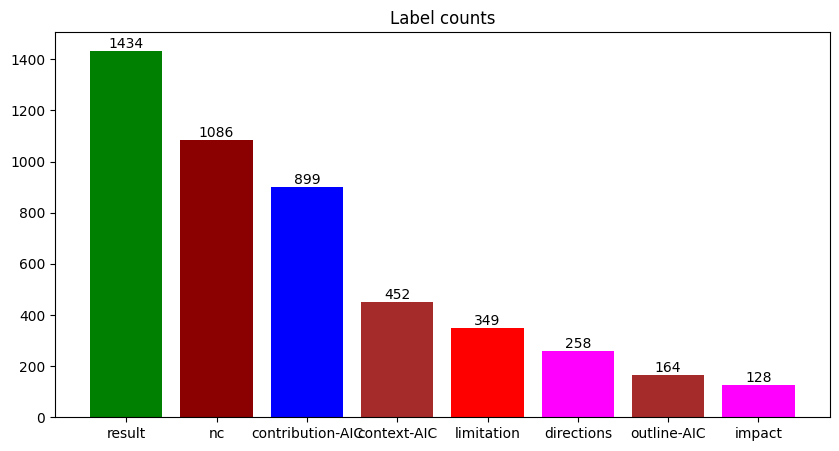

In [54]:
label_counts = {}

LABELS = ["context-AIC", "outline-AIC", "contribution-AIC", "result", "limitation", "impact", "directions"]
LABELS.append("nc")

for label in LABELS:
    label_counts[label] = seq_df[seq_df["label"].str.contains(label)].shape[0]

# sort the labels by frequency
label_counts = dict(sorted(label_counts.items(), key=lambda item: item[1], reverse=True))

# plot the label counts
palette_dict = {"nc": "darkred",
                "result":"green",
                "context-AIC":"brown",
                "outline-AIC":"brown",
                "contribution-AIC":"blue",
                "limitation":"red",
                "impact": "magenta",
                "directions": "magenta"}

plt.figure(figsize=(10, 5))
plt.bar(label_counts.keys(), label_counts.values(), color=[palette_dict[label] for label in label_counts.keys()])
plt.title("Label counts")

# Add values on top of the bars
for label, count in label_counts.items():
    plt.text(label, count, str(count), ha='center', va='bottom')

plt.show()

In [55]:
seq_lim = seq_df[seq_df["label"].str.contains("limitation")]
print(seq_lim.shape[0])

for lim in seq_lim["text"].values:
    print(lim)
    print()

349
Our error analysis reveals some different obstacles from English SRL to work on in the future. 

There are several promising avenues for extending this work to Portuguese (and other languages), but the datasets currently available in Portuguese are not as extensive as Google News or as well tested; so, in this paper the plug-in is used to identify the similarity between an input article in English and pre-classified articles in English. 

Second, the notion of similar is too broad. Texts can be similar but completely contradictory.

The errors described in this section are in addition to the errors due to misspellings and informal language. These erroneous results have been obtained from both version 1 and 2.

The positive word leads to the prediction by C-Feel-It where in fact, it is a negative tweet for the human annotator.

The words 'pain', 'killers', etc. in the tweet give an indication to C-Feel-It that the tweet is negative. This misguided implication is because of multiple 

In [117]:
seq_impact = seq_df[seq_df["label"].str.contains("impact")]
print(seq_impact.shape[0])

for impact in seq_impact["text"].values:
    print(impact)
    print()

128
We also introduce a new dataset for SRL in Indonesian conversational domain to encourage further research in this area 1 .

This is especially important in collaborative approaches to fact-checking where members of large teams will not know what content others have already fact-checked. 

Finally, we should be able to evaluate how much this approach helps the verification work, for example, by counting how many content items did not need to be verified again because similar, previously-verified items were correctly suggested by this tool.

A sentiment analyzer of this kind can be tuned to take inputs from different sources on the internet (for example, wall posts on facebook).

LRA has potential applications in many areas, including information extraction, word sense disambiguation, machine translation, and information retrieval.

Just as attributional similarity measures have proven to have many practical uses, we expect that relational similarity measures will soon become widely 

In [118]:
for i, row in seq_df.head(5).iterrows():
    print(row["label"])
    print(row["text"])
    print()

context-AIC
Most Semantic Role Labeling (SRL) approaches are supervised methods which require a significant amount of annotated corpus, and the annotation requires linguistic expertise.

contribution-AIC
In this paper, we propose a Multi-Task Active Learning framework for Semantic Role Labeling with Entity Recognition (ER) as the auxiliary task to alleviate the need for extensive data and use additional information from ER to help SRL. We evaluate our approach on Indonesian conversational dataset.

result
Our experiments show that multi-task active learning can outperform single-task active learning method and standard multi-task learning. According to our results, active learning is more efficient by using 12% less of training data compared to passive learning in both single-task and multi-task setting.

contribution-AIC#impact
We also introduce a new dataset for SRL in Indonesian conversational domain to encourage further research in this area 1 .

context-AIC
Semantic Role Labeling 

In [119]:
# average length of the sequences per label
seq_df["length"] = seq_df["ids"].apply(lambda x: len(x))
seq_df.groupby("label")["length"].describe().sort_values("mean", ascending=False)

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
nc,1086.0,5.872928,7.316698,1.0,1.00,3.0,7.00,70.0
context-AIC,412.0,5.172330,5.716490,1.0,1.00,3.0,7.00,45.0
result,1105.0,2.752941,2.722616,1.0,1.00,2.0,3.00,23.0
contribution-AIC,694.0,2.419308,2.009710,1.0,1.00,2.0,3.00,15.0
outline-AIC,110.0,2.390909,1.729907,1.0,1.00,1.5,4.00,10.0
limitation,140.0,1.950000,2.123270,1.0,1.00,1.0,2.00,21.0
directions,189.0,1.931217,1.795541,1.0,1.00,1.0,2.00,19.0
outline-AIC#contribution-AIC,42.0,1.571429,0.830599,1.0,1.00,1.0,2.00,4.0
limitation#impact,2.0,1.500000,0.707107,1.0,1.25,1.5,1.75,2.0


### In Abstracts

In [120]:
abstract_seq = []

for pt in seq_df["paper_title"].unique():
    paper = seq_df[seq_df["paper_title"] == pt]
    abstract = paper[paper["section"] == "abstract"]
    if abstract.shape[0] > 0:
        abstract_seq.append(abstract.label.values)

print(abstract_seq[0])

['context-AIC' 'contribution-AIC' 'result' 'contribution-AIC#impact']


In [121]:
abstract_seq[3]

array(['context-AIC', 'contribution-AIC'], dtype=object)

In [122]:
from collections import Counter

Counter([seq[0] for seq in abstract_seq]).most_common()

[('contribution-AIC', 83),
 ('context-AIC', 60),
 ('contribution-AIC#result', 4),
 ('nc', 4),
 ('context-AIC#impact', 2),
 ('contribution-AIC#impact', 1),
 ('impact', 1),
 ('outline-AIC', 1)]

In [123]:
Counter([seq[1] for seq in abstract_seq if len(seq) > 1 and seq[0] == "context-AIC"]).most_common(20)

[('contribution-AIC', 53),
 ('contribution-AIC#result', 3),
 ('result', 1),
 ('contribution-AIC#result#limitation', 1),
 ('context-AIC#impact', 1),
 ('nc', 1)]

In [124]:
Counter([tuple(seq) for seq in abstract_seq]).most_common(5)

[(('contribution-AIC', 'result'), 31),
 (('contribution-AIC',), 17),
 (('context-AIC', 'contribution-AIC', 'result'), 16),
 (('context-AIC', 'contribution-AIC'), 9),
 (('contribution-AIC', 'contribution-AIC#result'), 5)]

In [125]:
len([seq for seq in abstract_seq if seq[0] == "contribution-AIC" and len(seq) == 1])

17

In [126]:
# find the abstract_seq element with the highest length
max_len = 0
max_seq = []
for seq in abstract_seq:
    if len(seq) > max_len:
        max_len = len(seq)
        max_seq = seq

print(max_len)
[seq for seq in abstract_seq if len(seq) == max_len]

8


[array(['nc', 'contribution-AIC', 'context-AIC', 'contribution-AIC',
        'contribution-AIC#impact', 'result', 'contribution-AIC#result',
        'contribution-AIC#impact'], dtype=object)]

In [127]:
# count the number of times each sequence appears in abstract_seq
Counter([tuple(seq[:3]) for seq in abstract_seq]).most_common()

[(('contribution-AIC', 'result'), 31),
 (('context-AIC', 'contribution-AIC', 'result'), 30),
 (('contribution-AIC',), 17),
 (('context-AIC', 'contribution-AIC'), 9),
 (('contribution-AIC', 'result', 'contribution-AIC'), 7),
 (('contribution-AIC', 'contribution-AIC#result'), 5),
 (('context-AIC', 'contribution-AIC', 'contribution-AIC#result'), 4),
 (('contribution-AIC', 'contribution-AIC#result', 'result'), 4),
 (('context-AIC', 'contribution-AIC', 'context-AIC'), 4),
 (('contribution-AIC', 'context-AIC', 'contribution-AIC'), 3),
 (('contribution-AIC', 'contribution-AIC#result', 'contribution-AIC'), 3),
 (('contribution-AIC#result', 'contribution-AIC', 'result'), 2),
 (('nc', 'contribution-AIC', 'context-AIC'), 2),
 (('context-AIC', 'contribution-AIC', 'impact'), 1),
 (('contribution-AIC', 'context-AIC#impact', 'context-AIC'), 1),
 (('contribution-AIC', 'limitation', 'contribution-AIC'), 1),
 (('context-AIC#impact', 'contribution-AIC', 'context-AIC'), 1),
 (('contribution-AIC', 'context

In [128]:
Counter([seq[-1] for seq in abstract_seq]).most_common()

[('result', 67),
 ('contribution-AIC', 50),
 ('contribution-AIC#result', 13),
 ('impact', 5),
 ('outline-AIC', 5),
 ('contribution-AIC#impact', 3),
 ('nc', 3),
 ('result#limitation', 3),
 ('result#impact', 2),
 ('outline-AIC#contribution-AIC', 2),
 ('limitation#directions', 1),
 ('context-AIC', 1),
 ('result#directions', 1)]

In [129]:
data = []

for pt, seq in zip(list(anno["paper_title"].unique()), abstract_seq):
    data.append({"paper_title": pt, "sequence": seq, "length": len(seq)})

ab_seq = pd.DataFrame(data)
ab_seq.head()

,paper_title,sequence,length
0,Multi-Task Active Learning for Neural Semantic...,"[context-AIC, contribution-AIC, result, contri...",4
1,Text Similarity Using Word Embeddings to Class...,"[context-AIC, contribution-AIC, impact]",3
2,Learning Taxonomy for Text Segmentation by For...,[contribution-AIC],1
3,{C}-Feel-It: A Sentiment Analyzer for Micro-blogs,"[context-AIC, contribution-AIC]",2
4,Word-to-Word Models of Translational Equivalence,"[context-AIC, contribution-AIC, contribution-A...",6


In [130]:
ab_seq["length"].describe()

count    156.000000
mean       2.974359
std        1.381671
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        8.000000
Name: length, dtype: float64

In [131]:
[seq for seq in abstract_seq if "limitation" in "".join(seq)]

[array(['contribution-AIC', 'limitation', 'contribution-AIC'], dtype=object),
 array(['context-AIC', 'contribution-AIC', 'result',
        'limitation#directions'], dtype=object),
 array(['context-AIC', 'contribution-AIC', 'contribution-AIC#limitation',
        'result'], dtype=object),
 array(['contribution-AIC', 'contribution-AIC#limitation', 'context-AIC',
        'contribution-AIC', 'result'], dtype=object),
 array(['context-AIC', 'contribution-AIC#result#limitation',
        'result#limitation', 'contribution-AIC'], dtype=object),
 array(['context-AIC', 'contribution-AIC', 'result', 'result#limitation'],
       dtype=object),
 array(['contribution-AIC', 'result', 'result#limitation'], dtype=object),
 array(['contribution-AIC', 'result#limitation'], dtype=object)]

In [132]:
[seq for seq in abstract_seq if "impact" in "".join(seq)]

[array(['context-AIC', 'contribution-AIC', 'result',
        'contribution-AIC#impact'], dtype=object),
 array(['context-AIC', 'contribution-AIC', 'impact'], dtype=object),
 array(['contribution-AIC', 'context-AIC#impact', 'context-AIC',
        'contribution-AIC', 'result'], dtype=object),
 array(['context-AIC', 'contribution-AIC', 'result', 'impact'],
       dtype=object),
 array(['context-AIC#impact', 'contribution-AIC', 'context-AIC',
        'contribution-AIC'], dtype=object),
 array(['context-AIC', 'contribution-AIC', 'result', 'impact'],
       dtype=object),
 array(['contribution-AIC', 'context-AIC#impact', 'contribution-AIC'],
       dtype=object),
 array(['nc', 'contribution-AIC', 'context-AIC', 'contribution-AIC',
        'contribution-AIC#impact', 'result', 'contribution-AIC#result',
        'contribution-AIC#impact'], dtype=object),
 array(['contribution-AIC#impact', 'contribution-AIC'], dtype=object),
 array(['impact', 'contribution-AIC', 'result', 'result#impact'],
     

In [133]:
[seq for seq in abstract_seq if "directions" in "".join(seq)]

[array(['context-AIC', 'contribution-AIC', 'result',
        'limitation#directions'], dtype=object),
 array(['context-AIC', 'contribution-AIC', 'result', 'result#directions'],
       dtype=object),
 array(['nc', 'contribution-AIC', 'result', 'directions',
        'contribution-AIC'], dtype=object)]

In [134]:
seq_df[(seq_df["label"].str.contains("limitation")) & (seq_df["section"] == "abstract")].text.values

array(['Because of the sentential structure differences between English and Chinese, matching at the sentence level as in many other works may result in frequent matching of several sentences en masse.',
       'The result demonstrates that named entity recognition remains a challenge in codeswitched texts and warrants further work.',
       'The approach of using a web-based measure can be applied directly to sentences with multiple error characters, either consecutive or not, and is not optimized for one-character error correction of Chinese sentences.',
       'On the contrary, the datadriven system we use is generic, and has not been specifically designed to deal with Basque.',
       'We have converted our independent mixture systems to tied mixtures and have obtained mixed results: a 13% improvement in speaker-dependent recognition without cross-word triphone models, but no improvement in our speaker-dependent system with cross-word boundary triphone models or in our speaker-inde

## In Conclusion

In [135]:
concl_seq = []

for pt in seq_df["paper_title"].unique():
    paper = seq_df[seq_df["paper_title"] == pt]
    concl = paper[paper["section"].str.lower().str.contains("concl")]
    if concl.shape[0] > 0:
        concl_seq.append(concl.label.values)

print(concl_seq[0])

['contribution-AIC' 'result' 'limitation#directions' 'context-AIC'
 'context-AIC#directions']


In [136]:
len(concl_seq)

132

In [137]:
Counter([seq[-1] for seq in concl_seq]).most_common()

[('directions', 60),
 ('result', 20),
 ('nc', 11),
 ('impact', 11),
 ('contribution-AIC', 9),
 ('impact#directions', 5),
 ('result#directions', 3),
 ('result#limitation', 2),
 ('limitation#directions', 2),
 ('contribution-AIC#result', 2),
 ('context-AIC', 2),
 ('limitation', 2),
 ('context-AIC#directions', 1),
 ('result#impact', 1),
 ('contribution-AIC#impact', 1)]

In [138]:
Counter([(seq[-2], seq[-1]) if len(seq)>2 else (seq[-1]) for seq in concl_seq]).most_common()

[(('result', 'directions'), 21),
 ('result', 13),
 (('contribution-AIC', 'directions'), 9),
 ('directions', 7),
 (('limitation', 'directions'), 6),
 (('directions', 'impact'), 5),
 (('directions', 'nc'), 4),
 (('impact', 'directions'), 4),
 (('context-AIC', 'directions'), 4),
 (('limitation#directions', 'directions'), 4),
 (('result', 'contribution-AIC'), 4),
 ('contribution-AIC', 3),
 (('contribution-AIC', 'result'), 3),
 ('nc', 3),
 (('directions', 'impact#directions'), 2),
 (('directions', 'result#limitation'), 2),
 ('impact', 2),
 (('contribution-AIC#result', 'directions'), 2),
 (('directions', 'context-AIC'), 2),
 (('contribution-AIC#result', 'result'), 2),
 (('result', 'impact#directions'), 2),
 (('context-AIC', 'context-AIC#directions'), 1),
 (('result', 'result#impact'), 1),
 ('contribution-AIC#impact', 1),
 (('result', 'limitation#directions'), 1),
 (('result#limitation#impact', 'nc'), 1),
 (('contribution-AIC', 'impact'), 1),
 (('result', 'contribution-AIC#result'), 1),
 (('r

In [139]:
Counter([tuple(seq) for seq in concl_seq]).most_common()

[(('contribution-AIC', 'result'), 10),
 (('contribution-AIC', 'result', 'directions'), 8),
 (('contribution-AIC', 'directions'), 6),
 (('contribution-AIC',), 3),
 (('contribution-AIC', 'result', 'impact', 'directions'), 2),
 (('result', 'impact'), 2),
 (('result',), 2),
 (('contribution-AIC', 'result', 'limitation', 'directions'), 2),
 (('contribution-AIC', 'result', 'contribution-AIC', 'result', 'directions'),
  2),
 (('nc',), 2),
 (('contribution-AIC', 'result', 'contribution-AIC', 'directions'), 2),
 (('contribution-AIC',
   'result',
   'limitation#directions',
   'context-AIC',
   'context-AIC#directions'),
  1),
 (('contribution-AIC',
   'directions',
   'limitation',
   'directions',
   'context-AIC',
   'directions',
   'impact#directions'),
  1),
 (('contribution-AIC', 'directions', 'nc'), 1),
 (('context-AIC',
   'contribution-AIC',
   'result',
   'impact#directions',
   'directions',
   'impact'),
  1),
 (('contribution-AIC',
   'result',
   'contribution-AIC',
   'result',

## Linguistic characteristics

Are there some linguistic characteristics that allow to differentiate claim categories, such as vocabulary, verb tense, negation, voice, etc. ?

In [140]:
# use spacy model
import spacy
from utils.Corpus import Corpus

nlp = Corpus.init_spacy_model()
print(len(nlp.vocab))

766


In [141]:
doc = nlp("We believe that text summarization is a crucial task in NLP.")

for tok in doc:
    print(tok.text, tok.pos_, tok.lemma_, tok.dep_, tok.head, tok.ent_type, tok.morph, tok.sentiment, tok.prob)

We PRON we nsubj believe 0 Case=Nom|Number=Plur|Person=1|PronType=Prs 0.0 -20.0
believe VERB believe ROOT believe 0 Tense=Pres|VerbForm=Fin 0.0 -20.0
that SCONJ that mark is 0  0.0 -20.0
text NOUN text compound summarization 0 Number=Sing 0.0 -20.0
summarization NOUN summarization nsubj is 0 Number=Sing 0.0 -20.0
is AUX be ccomp believe 0 Mood=Ind|Number=Sing|Person=3|Tense=Pres|VerbForm=Fin 0.0 -20.0
a DET a det task 0 Definite=Ind|PronType=Art 0.0 -20.0
crucial ADJ crucial amod task 0 Degree=Pos 0.0 -20.0
task NOUN task attr is 0 Number=Sing 0.0 -20.0
in ADP in prep task 0  0.0 -20.0
NLP PROPN NLP pobj in 383 Number=Sing 0.0 -20.0
. PUNCT . punct believe 0 PunctType=Peri 0.0 -20.0


In [142]:
tok = doc[5]
print("Token:", tok)

for anc in tok.ancestors:
    print("Ancestors:", anc)

for conj in tok.conjuncts:
    print("Coordinated tokens:", conj)

for child in tok.children:
    print("Children:", child)

print(tok.subtree)

Token: is
Ancestors: believe
Children: that
Children: summarization
Children: task


In [143]:
sents = []
for sent in doc.sents:
    sents.append(sent)

sent = sents[0]

print(sent.text)
print(sent.root, type(sent.root))

We believe that text summarization is a crucial task in NLP.
believe <class 'spacy.tokens.token.Token'>


In [144]:
len(tok.vocab)

773

In [145]:
vocabs = {}

for l in tqdm(LABELS):

    sents_l = anno[anno["label"].str.contains(l)].text.values
    vocabs[l] = {"tokens": []}

    for sent in sents_l:
        doc = nlp(sent)

        for tok in doc:
            vocabs[l]["tokens"].append(tok)

  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [02:13<00:00, 16.71s/it]


In [146]:
for l in tqdm(LABELS):
    vocabs[l]["lemmas"] = [tok.lemma_ for tok in vocabs[l]["tokens"] if not tok.is_stop and not tok.pos_ == "PUNCT"]

100%|██████████| 8/8 [00:00<00:00, 58.34it/s]


In [147]:
for l in LABELS:
    print(l)
    print(Counter(vocabs[l]["lemmas"]).most_common(10))

context-AIC
[('word', 419), ('language', 418), ('al', 387), ('et', 385), ('.', 321), ('model', 307), ('system', 207), ('sentence', 205), ('task', 204), ('text', 195)]
outline-AIC
[('section', 269), ('present', 70), ('work', 65), ('describe', 55), ('3', 54), ('4', 54), ('2', 53), ('paper', 52), ('result', 50), ('5', 45)]
contribution-AIC
[('model', 366), ('language', 283), ('paper', 273), ('base', 258), ('word', 241), ('system', 202), ('approach', 186), ('use', 174), ('text', 169), ('task', 168)]
result
[('model', 639), ('result', 533), ('%', 477), ('word', 406), ('system', 381), ('performance', 322), ('language', 290), ('-', 264), ('datum', 254), ('feature', 248)]
limitation
[('system', 83), ('word', 77), ('model', 66), ('datum', 51), ('language', 48), ('result', 47), ('error', 45), ('work', 38), ('-', 35), ('problem', 35)]
impact
[('language', 47), ('system', 28), ('model', 26), ('application', 22), ('information', 17), ('use', 16), ('research', 14), ('important', 14), ('need', 14), (

In [148]:
result_verbs = [tok.lemma_ for tok in vocabs["result"]["tokens"] if tok.pos_ == "VERB"]
Counter(result_verbs).most_common(15)

[('use', 418),
 ('show', 403),
 ('have', 242),
 ('base', 200),
 ('achieve', 171),
 ('perform', 163),
 ('find', 157),
 ('improve', 156),
 ('see', 153),
 ('compare', 122),
 ('outperform', 115),
 ('give', 115),
 ('learn', 113),
 ('provide', 107),
 ('be', 102)]

In [149]:
contribution_verbs = [tok.lemma_ for tok in vocabs["contribution-AIC"]["tokens"] if tok.pos_ == "VERB"]
Counter(contribution_verbs).most_common(15)

[('use', 424),
 ('base', 239),
 ('propose', 164),
 ('present', 146),
 ('describe', 104),
 ('learn', 103),
 ('show', 73),
 ('train', 72),
 ('develop', 72),
 ('give', 65),
 ('generate', 65),
 ('make', 62),
 ('provide', 61),
 ('extract', 60),
 ('evaluate', 59)]

In [150]:
limitation_verbs = [tok.lemma_ for tok in vocabs["limitation"]["tokens"] if tok.pos_ == "VERB"]
Counter(limitation_verbs).most_common(15)

[('use', 65),
 ('have', 48),
 ('show', 25),
 ('give', 24),
 ('be', 21),
 ('need', 21),
 ('require', 20),
 ('make', 19),
 ('compare', 17),
 ('provide', 16),
 ('generate', 16),
 ('lead', 15),
 ('find', 15),
 ('base', 15),
 ('remain', 14)]

In [151]:
directions_verbs = [tok.lemma_ for tok in vocabs["directions"]["tokens"] if tok.pos_ == "VERB"]
Counter(directions_verbs).most_common(15)

[('use', 80),
 ('plan', 38),
 ('base', 35),
 ('improve', 32),
 ('have', 25),
 ('investigate', 24),
 ('include', 19),
 ('need', 17),
 ('be', 17),
 ('require', 17),
 ('evaluate', 17),
 ('consider', 16),
 ('extend', 16),
 ('provide', 16),
 ('learn', 15)]

In [152]:
impact_verbs = [tok.lemma_ for tok in vocabs["impact"]["tokens"] if tok.pos_ == "VERB"]
Counter(impact_verbs).most_common(15)

[('use', 15),
 ('have', 13),
 ('provide', 13),
 ('base', 12),
 ('develop', 12),
 ('believe', 11),
 ('evaluate', 9),
 ('make', 9),
 ('help', 8),
 ('include', 8),
 ('hope', 8),
 ('need', 7),
 ('serve', 6),
 ('learn', 6),
 ('contribute', 6)]

In [153]:
result_pron = [tok.lemma_ for tok in vocabs["result"]["tokens"] if tok.pos_ == "PRON"]
Counter(result_pron).most_common(5)

[('we', 815), ('our', 450), ('it', 418), ('that', 326), ('which', 295)]

In [154]:
context_pron = [tok.lemma_ for tok in vocabs["context-AIC"]["tokens"] if tok.pos_ == "PRON"]
Counter(context_pron).most_common(5)

[('that', 273), ('it', 223), ('which', 207), ('we', 156), ('they', 146)]